In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


### Import libraries

In [2]:
!pip install lazypredict

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, f1_score, precision_score, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from lazypredict.Supervised import LazyRegressor, LazyClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

In [4]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

split = len(train)

data = pd.concat([train, test], axis=0).reset_index(drop=True)
Id = data['PassengerId']

In [5]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [6]:
data.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

<Axes: xlabel='HomePlanet', ylabel='Count'>

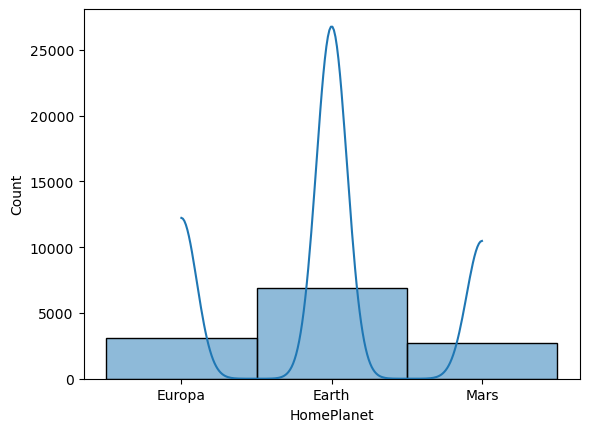

In [7]:
sns.histplot(data['HomePlanet'].dropna(), kde=True)

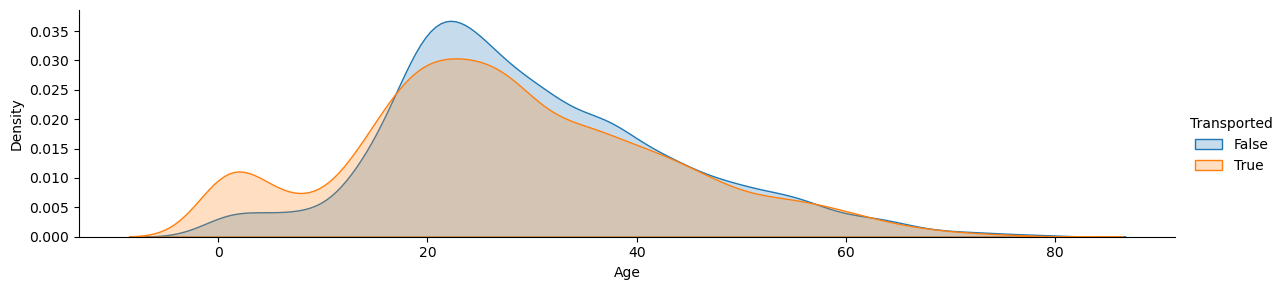

In [8]:
a = sns.FacetGrid(train, hue = 'Transported', aspect=4 )
a.map(sns.kdeplot, 'Age', fill = True )
a.add_legend()

<Axes: xlabel='Age', ylabel='Count'>

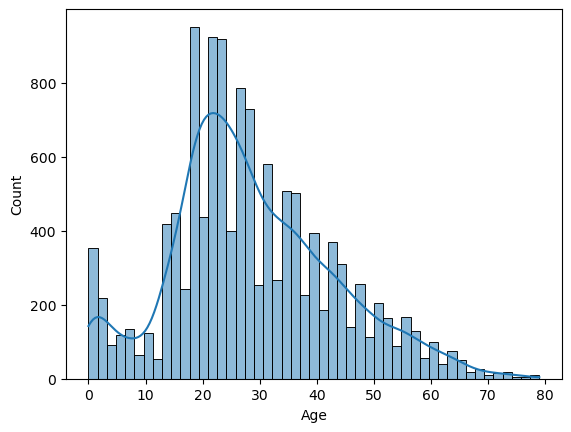

In [9]:
sns.histplot(data['Age'].dropna(), kde=True)

## Data cleaning

In [10]:
data.head(50)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.00,False,0.00,483.00,0.00,291.00,0.00,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.00,False,42.00,1539.00,3.00,0.00,0.00,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.00,False,0.00,0.00,0.00,0.00,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.00,False,0.00,785.00,17.00,216.00,0.00,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.00,False,0.00,0.00,0.00,0.00,0.00,Erraiam Flatic,True


In [11]:
# divide PassengerId into Group and Id
data[['Group', 'Id']] = data['PassengerId'].str.split('_', expand=True)
data['Group'] = data['Group'].apply(lambda x: f'{x:04}').astype(int)
data['Id'] = data['Id'].apply(lambda x: f'{x:02}').astype(int)

# drop PassengerId
data = data.drop(['PassengerId'], axis=1)

In [12]:
# Calculate total spent
data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0).astype(int)
data['TotalSpent'] = data['RoomService']+data['FoodCourt']+data['ShoppingMall']+data['Spa']+data['VRDeck']
data = data.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1)

In [13]:
# Fill NaN Age
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [14]:
# Change string to numeric
data['HomePlanet'] = data['HomePlanet'].fillna(0).map({'Europa':1, 'Earth':2, 'Mars':3})
data['Destination'] = data['Destination'].fillna(0).map({'TRAPPIST-1e':1, 'PSO J318.5-22':2, '55 Cancri e':3})
data['CryoSleep'] = data['CryoSleep'].fillna(0).map({False:0, True:1})
data['Transported'] = data['Transported'].fillna(0).map({False:0, True:1})
data['VIP'] = data['VIP'].fillna(0).map({False:0, True:1})

In [15]:
# drop the rest
data = data.drop(['Cabin', 'Name'], axis=1)


In [16]:
data['Destination'].unique()

array([ 1.,  2.,  3., nan])

In [17]:
data['HomePlanet'] = data['HomePlanet'].fillna(0)
data['Destination'] = data['Destination'].fillna(0)

In [18]:
train = data[:split]
test = data[split:]

In [19]:
X = train.drop(['Transported'], axis=1)
y = train['Transported']

In [20]:
X.isnull().sum()

HomePlanet     0
CryoSleep      0
Destination    0
Age            0
VIP            0
Group          0
Id             0
TotalSpent     0
dtype: int64

## Model

In [21]:
#scaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [23]:
lc = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = lc.fit(X_train, X_test, y_train, y_test)
print(models)

  3%|▎         | 1/29 [00:00<00:11,  2.34it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7372052903967797, 'Balanced Accuracy': 0.7376692885054461, 'ROC AUC': 0.737669288505446, 'F1 Score': 0.736675213339988, 'Time taken': 0.42686915397644043}


  7%|▋         | 2/29 [00:00<00:09,  2.93it/s]

{'Model': 'BaggingClassifier', 'Accuracy': 0.6923519263944796, 'Balanced Accuracy': 0.6930927379563415, 'ROC AUC': 0.6930927379563415, 'F1 Score': 0.6906714602216766, 'Time taken': 0.27728843688964844}
{'Model': 'BernoulliNB', 'Accuracy': 0.7291546866014951, 'Balanced Accuracy': 0.7302588239029153, 'ROC AUC': 0.7302588239029152, 'F1 Score': 0.725804835310479, 'Time taken': 0.026992321014404297}


 21%|██        | 6/29 [00:03<00:11,  1.95it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.723404255319149, 'Balanced Accuracy': 0.724687747202887, 'ROC AUC': 0.724687747202887, 'F1 Score': 0.7187289658906256, 'Time taken': 2.470768928527832}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.6520989074180563, 'Balanced Accuracy': 0.6519475949722074, 'ROC AUC': 0.6519475949722074, 'F1 Score': 0.6520070600020472, 'Time taken': 0.08572578430175781}
{'Model': 'DummyClassifier', 'Accuracy': 0.5048878665899943, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.33877840799848297, 'Time taken': 0.020009517669677734}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.6394479585968947, 'Balanced Accuracy': 0.6392841930371793, 'ROC AUC': 0.6392841930371793, 'F1 Score': 0.6393382131631689, 'Time taken': 0.026794910430908203}


 38%|███▊      | 11/29 [00:04<00:05,  3.14it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.7038527889591719, 'Balanced Accuracy': 0.7043810634982366, 'ROC AUC': 0.7043810634982367, 'F1 Score': 0.7030560349824068, 'Time taken': 0.9892048835754395}
{'Model': 'GaussianNB', 'Accuracy': 0.7199539965497412, 'Balanced Accuracy': 0.7204950539580242, 'ROC AUC': 0.7204950539580242, 'F1 Score': 0.7191665059609499, 'Time taken': 0.023715734481811523}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6940770557791834, 'Balanced Accuracy': 0.6943626497768395, 'ROC AUC': 0.6943626497768396, 'F1 Score': 0.6938560090941513, 'Time taken': 0.1493532657623291}


 41%|████▏     | 12/29 [00:06<00:10,  1.55it/s]

{'Model': 'LabelPropagation', 'Accuracy': 0.6894767107533065, 'Balanced Accuracy': 0.6897843530989817, 'ROC AUC': 0.6897843530989818, 'F1 Score': 0.6892116286937643, 'Time taken': 2.057785749435425}


 45%|████▍     | 13/29 [00:09<00:19,  1.22s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.6889016676250719, 'Balanced Accuracy': 0.6892261210278878, 'ROC AUC': 0.6892261210278878, 'F1 Score': 0.6886033349064885, 'Time taken': 3.356738567352295}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7228292121909143, 'Balanced Accuracy': 0.7241407591427037, 'ROC AUC': 0.7241407591427037, 'F1 Score': 0.7179292938312364, 'Time taken': 0.19095826148986816}


 55%|█████▌    | 16/29 [00:10<00:08,  1.46it/s]

{'Model': 'LinearSVC', 'Accuracy': 0.7228292121909143, 'Balanced Accuracy': 0.7241407591427037, 'ROC AUC': 0.7241407591427037, 'F1 Score': 0.7179292938312364, 'Time taken': 0.5829517841339111}
{'Model': 'LogisticRegression', 'Accuracy': 0.7239792984473835, 'Balanced Accuracy': 0.7252234912521596, 'ROC AUC': 0.7252234912521596, 'F1 Score': 0.7196049235842302, 'Time taken': 0.11366653442382812}
{'Model': 'NearestCentroid', 'Accuracy': 0.7274295572167913, 'Balanced Accuracy': 0.7286066157114548, 'ROC AUC': 0.7286066157114549, 'F1 Score': 0.7235803700206608, 'Time taken': 0.08156299591064453}


 69%|██████▉   | 20/29 [00:16<00:08,  1.02it/s]

{'Model': 'NuSVC', 'Accuracy': 0.7320299022426682, 'Balanced Accuracy': 0.7328138600292609, 'ROC AUC': 0.7328138600292609, 'F1 Score': 0.7304006967302247, 'Time taken': 5.224836826324463}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.4088556641748131, 'Balanced Accuracy': 0.40653911989819536, 'ROC AUC': 0.40653911989819547, 'F1 Score': 0.37390075024015035, 'Time taken': 0.07772564888000488}
{'Model': 'Perceptron', 'Accuracy': 0.5761932144910868, 'Balanced Accuracy': 0.5749439783691687, 'ROC AUC': 0.5749439783691688, 'F1 Score': 0.5690762553246518, 'Time taken': 0.10160183906555176}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.7251293847038528, 'Balanced Accuracy': 0.7258114868815464, 'ROC AUC': 0.7258114868815464, 'F1 Score': 0.7238761402643401, 'Time taken': 0.08784627914428711}


 76%|███████▌  | 22/29 [00:17<00:06,  1.15it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.7096032202415181, 'Balanced Accuracy': 0.7101995084382995, 'ROC AUC': 0.7101995084382996, 'F1 Score': 0.7085983401058095, 'Time taken': 1.206239938735962}
{'Model': 'RidgeClassifier', 'Accuracy': 0.7228292121909143, 'Balanced Accuracy': 0.7241407591427037, 'ROC AUC': 0.7241407591427037, 'F1 Score': 0.7179292938312364, 'Time taken': 0.08485937118530273}


 86%|████████▌ | 25/29 [00:18<00:02,  1.89it/s]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7228292121909143, 'Balanced Accuracy': 0.7241407591427037, 'ROC AUC': 0.7241407591427037, 'F1 Score': 0.7179292938312364, 'Time taken': 0.16173601150512695}
{'Model': 'SGDClassifier', 'Accuracy': 0.7222541690626797, 'Balanced Accuracy': 0.7235825270716099, 'ROC AUC': 0.7235825270716099, 'F1 Score': 0.7172124379824747, 'Time taken': 0.14224576950073242}


 90%|████████▉ | 26/29 [00:20<00:02,  1.02it/s]

{'Model': 'SVC', 'Accuracy': 0.7452558941920644, 'Balanced Accuracy': 0.7461929101881322, 'ROC AUC': 0.7461929101881322, 'F1 Score': 0.7430200522699417, 'Time taken': 2.601687431335449}


 97%|█████████▋| 28/29 [00:21<00:00,  1.33it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.7285796434732605, 'Balanced Accuracy': 0.7290709272208244, 'ROC AUC': 0.7290709272208244, 'F1 Score': 0.7279592018824701, 'Time taken': 0.7523305416107178}


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.7366302472685451, 'Balanced Accuracy': 0.7373696686852973, 'ROC AUC': 0.7373696686852973, 'F1 Score': 0.7352141566632858, 'Time taken': 0.9016857147216797}
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.75               0.75     0.75      0.74   
AdaBoostClassifier                 0.74               0.74     0.74      0.74   
LGBMClassifier                     0.74               0.74     0.74      0.74   
NuSVC                              0.73               0.73     0.73      0.73   
BernoulliNB                        0.73               0.73     0.73      0.73   
XGBClassifier                      0.73               0.73     0.73      0.73   
NearestCentroid                    0.73               0.73     0.73      0.72   
QuadraticDiscriminantAnalysis      0.73               0.73     0.73      

## Support Vector Classification.

In [24]:
from sklearn.svm import SVC

msvc = SVC(gamma='auto',)
msvc.fit(X_train, y_train)

SVC(gamma='auto')

In [25]:
y_pred = msvc.predict(X_test)

In [26]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("AUC-ROC Score: ", roc_auc_score(y_test, y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))

Accuracy Score:  0.7222541690626797
AUC-ROC Score:  0.7235825270716099
Mean Squared Error:  0.2777458309373203
